# Liesel-GAM Demo Notebook

## Setup and Imports

In [ ]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [9]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [10]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


## Model Definition

### Setup response model

In [11]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [12]:
loc += tb.rs("income", cluster="district", noncentered=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


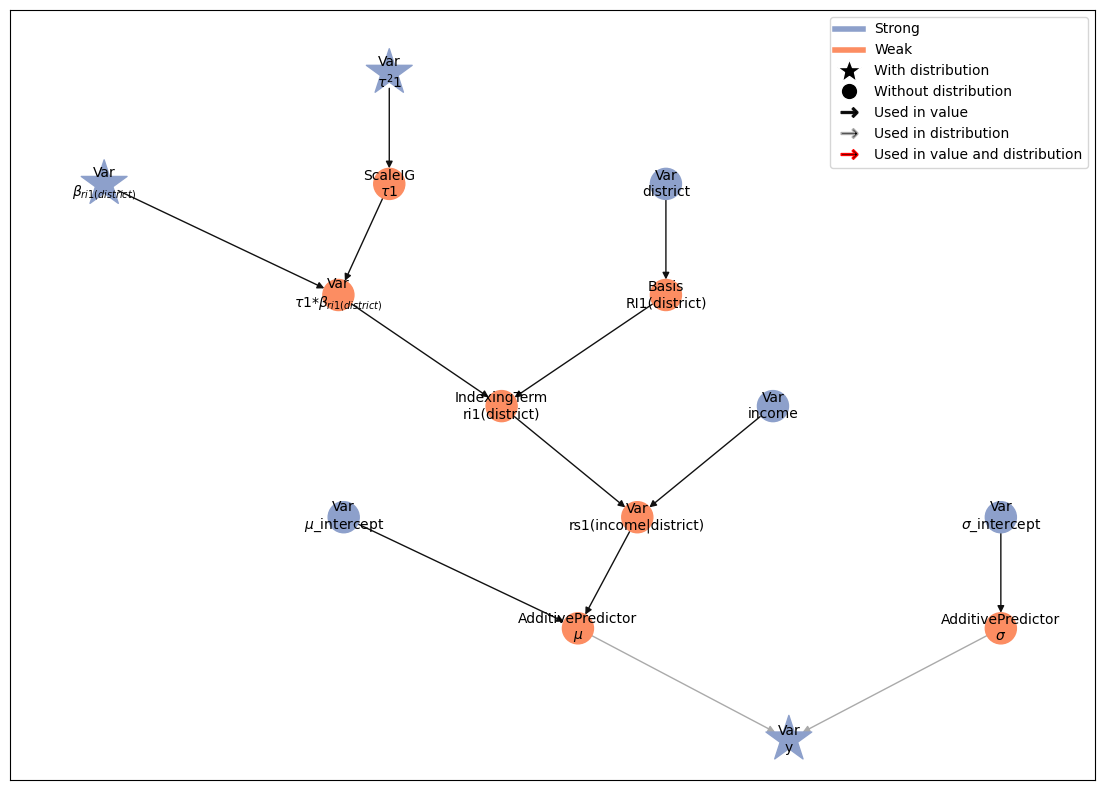

In [13]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ri1(district)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.24chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1535.81chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1564.75chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - 

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                                  kernel       mean        sd     q_0.05  \
parameter               index                                              
$\beta_{ri1(district)}$ (0,)   kernel_02  -0.302155  0.984721  -1.917585   
                        (1,)   kernel_02  -0.233986  0.981665  -1.810296   
                        (2,)   kernel_02  -0.068620  0.953493  -1.630181   
                        (3,)   kernel_02  -0.015690  0.990575  -1.632579   
                        (4,)   kernel_02   0.101238  0.964886  -1.516347   
                        (5,)   kernel_02  -0.137498  0.962041  -1.699056   
                        (6,)   kernel_02  -0.308762  1.055092  -2.049339   
                        (7,)   kernel_02   0.022577  0.941838  -1.504671   
                        (8,)   kernel_02  -0.062771  0.961544  -1.669871   
                        (9,)   kernel_02  -0.024762  0.986514  -1.670009   
                        (10,)  kernel_02   0.205557  1.017103  -1.473466   
                        (11,)  kernel_02   0.144018  0.996172  -1.508315   
                        (12,)  kernel_02   0.077025  0.966730  -1.530089   
                        (13,)  kernel_02   0.141249  0.975995  -1.457171   
                        (14,)  kernel_02   0.093166  0.983564  -1.512740   
                        (15,)  kernel_02   0.141063  1.007260  -1.536509   
                        (16,)  kernel_02  -0.018923  0.991719  -1.649004   
                        (17,)  kernel_02   0.064574  0.972077  -1.545785   
                        (18,)  kernel_02   0.153297  1.005837  -1.469567   
                        (19,)  kernel_02  -0.575300  0.995840  -2.169219   
                        (20,)  kernel_02   0.023239  0.971649  -1.561807   
                        (21,)  kernel_02  -0.024491  0.956893  -1.592010   
                        (22,)  kernel_02  -0.225336  0.957959  -1.792009   
                        (23,)  kernel_02  -0.006038  0.976818  -1.605466   
                        (24,)  kernel_02   0.187273  1.023613  -1.459918   
                        (25,)  kernel_02   0.036260  0.986744  -1.589388   
                        (26,)  kernel_02   0.152482  1.014748  -1.489527   
                        (27,)  kernel_02   0.135969  0.993416  -1.505066   
                        (28,)  kernel_02   0.182021  0.996789  -1.442233   
                        (29,)  kernel_02   0.338416  1.014929  -1.350088   
                        (30,)  kernel_02  -0.253881  0.974686  -1.807612   
                        (31,)  kernel_02  -0.208918  0.977002  -1.800202   
                        (32,)  kernel_02   0.058545  0.989055  -1.550131   
                        (33,)  kernel_02  -0.133464  0.988862  -1.749255   
                        (34,)  kernel_02   0.033315  0.966427  -1.562127   
                        (35,)  kernel_02  -0.255405  0.976303  -1.802593   
                        (36,)  kernel_02   0.035453  0.934786  -1.506883   
                        (37,)  kernel_02   0.156618  1.006603  -1.519621   
                        (38,)  kernel_02  -0.207333  0.973217  -1.801668   
                        (39,)  kernel_02  -0.342917  0.934698  -1.862056   
                        (40,)  kernel_02  -0.258018  0.976723  -1.808318   
                        (41,)  kernel_02  -0.275362  0.967247  -1.818342   
                        (42,)  kernel_02  -0.003823  0.968472  -1.605014   
                        (43,)  kernel_02  -0.107633  0.956048  -1.647243   
                        (44,)  kernel_02  -0.074355  0.979056  -1.679012   
                        (45,)  kernel_02  -0.253568  0.992310  -1.842330   
                        (46,)  kernel_02  -0.098045  0.972382  -1.663520   
                        (47,)  kernel_02  -0.044891  0.989063  -1.644966   
                        (48,)  kernel_02  -0.158925  0.973308  -1.742793   
$\mu$_intercept         ()     kernel_01  35.642735  2.655650  31.319125   
$\sigma$_intercept      ()  

## Plots

In [16]:
samples = results.get_posterior_samples()

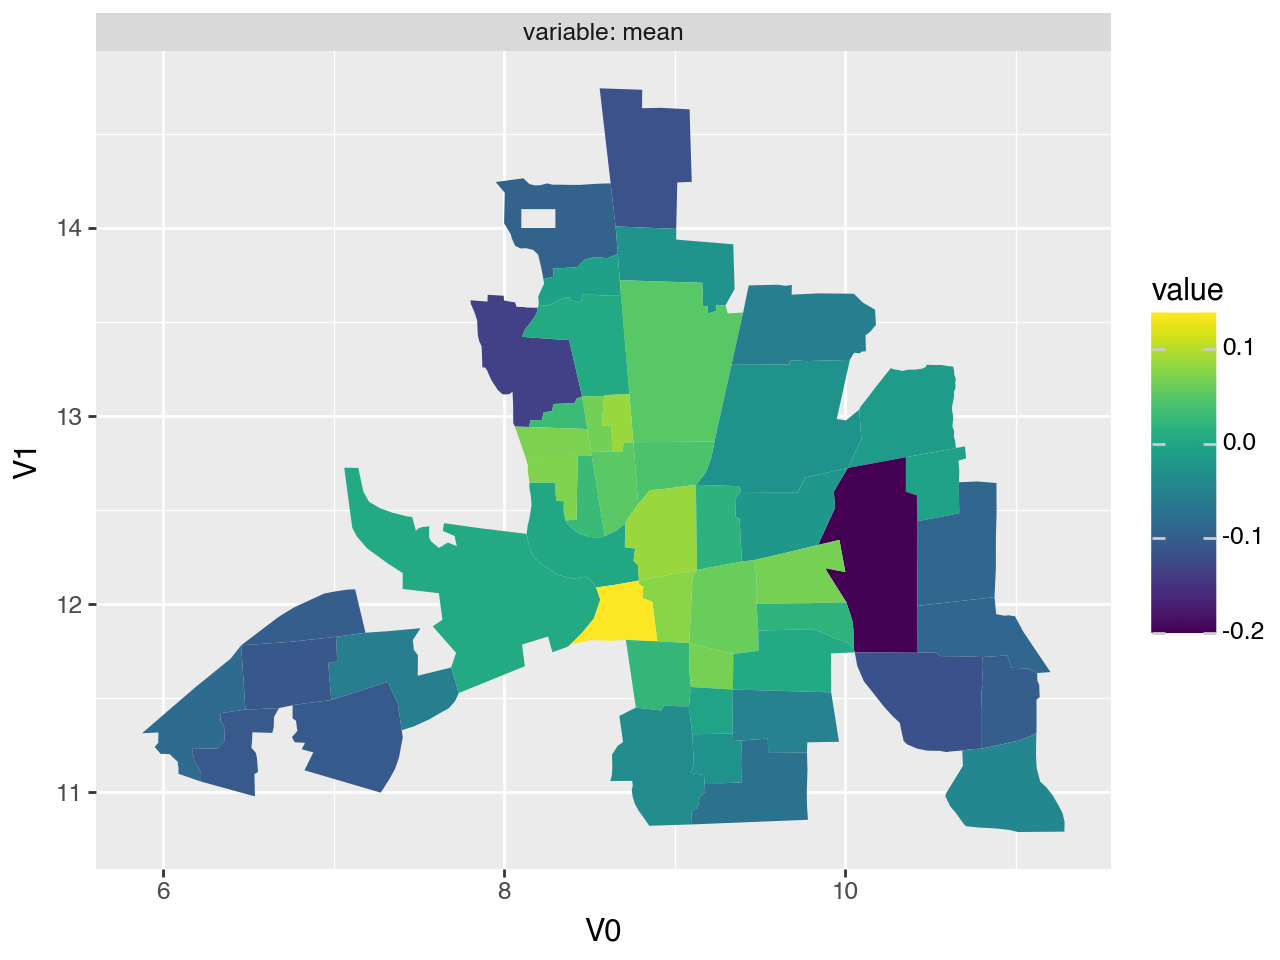

In [17]:
gam.plot_regions(model.vars["ri1(district)"], samples, polys=polys)

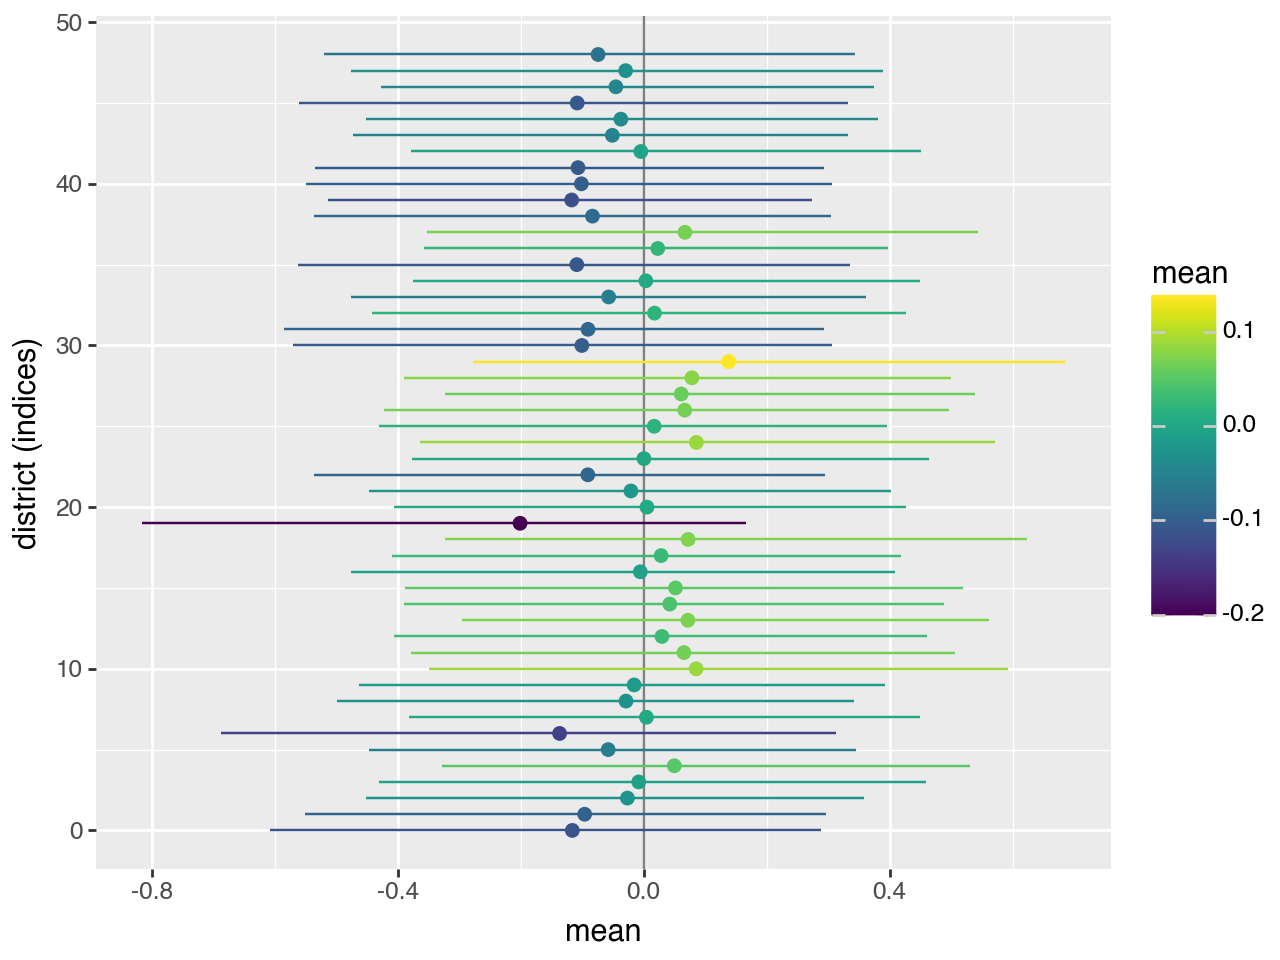

In [18]:
gam.plot_forest(model.vars["ri1(district)"], samples)

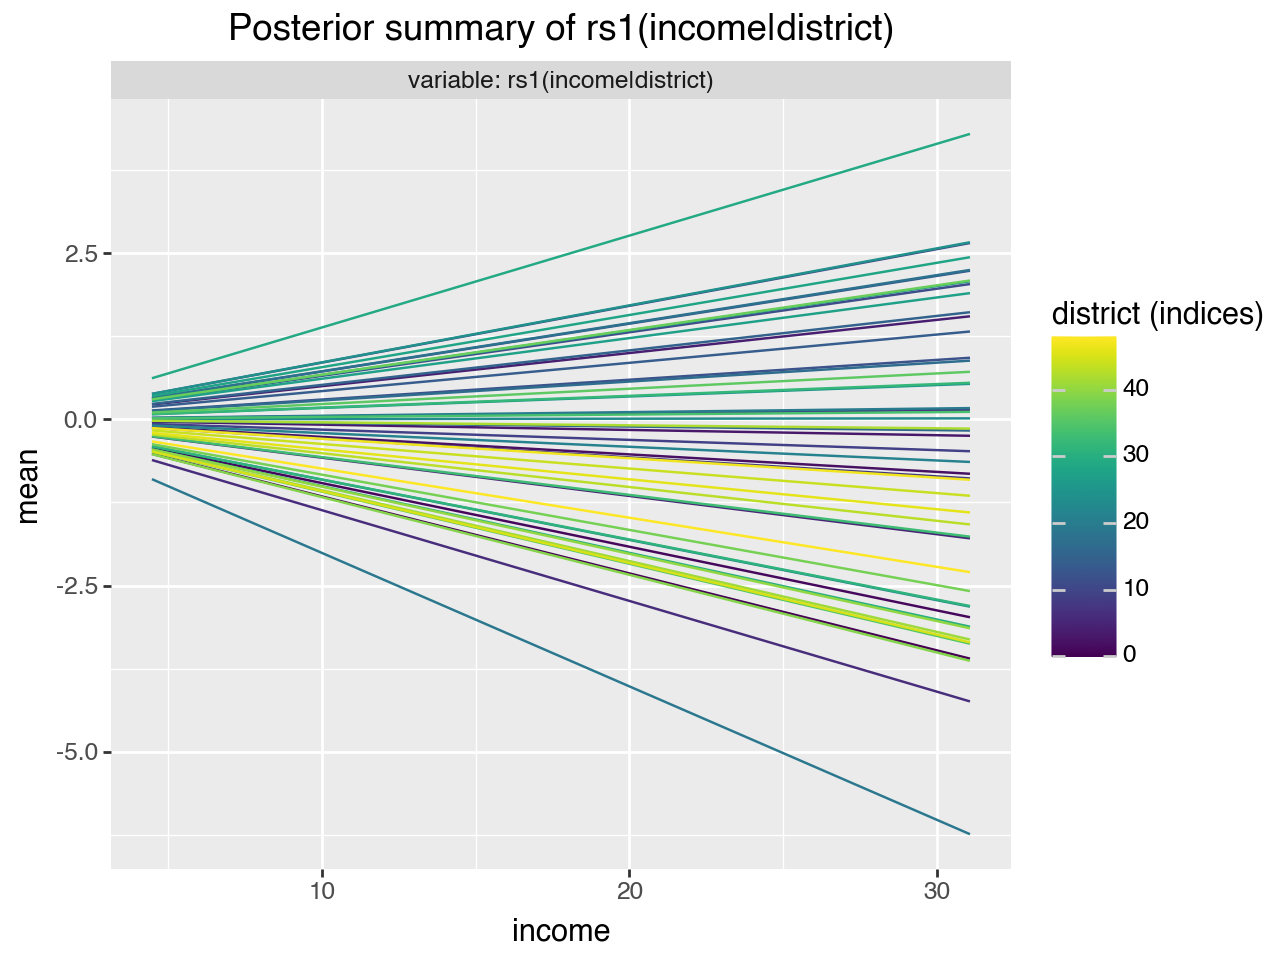

In [ ]:
gam.plot_1d_smooth_clustered(
    term=model.vars["rs1(income|district)"],
    x=model.vars["income"],
    cluster=model.vars["district"],
    samples=samples,
    ngrid=10,
)